In [ ]:
# @title Sel 1: Setup Lingkungan dan Impor Library
!pip install -q segmentation-models-pytorch
!pip install -q albumentations==1.3.1

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from skimage.morphology import skeletonize
from google.colab import drive
from PIL import Image
import base64
from io import BytesIO

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 8.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import kagglehub

path = kagglehub.dataset_download("balraj98/deepglobe-road-extraction-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.79G/3.79G [00:39<00:00, 103MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/deepglobe-road-extraction-dataset/versions/2


In [ ]:
# @title Sel 3: Konfigurasi Proyek
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4 # adalah jumlah gambar yang di proses per 1 kali proses, misalkan ada 1000 gambar, 1000/4 = 250 gambar, 1/250 s.d 250/250
NUM_EPOCHS = 10 # perulangan pelatihan
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
PIN_MEMORY = True

TRAIN_DIR = f"{path}/train/"
VAL_DIR = f"{path}/valid/"

MODEL_SAVE_PATH = "/content/drive/MyDrive/unet_road_extraction.pth"

In [ ]:
# @title Sel 4: Augmentasi Data

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), # mengubah ukuran gambar
        A.Rotate(limit=35, p=1.0), # rotasi gambar sampai 35 kali sebesar 1 derajat
        A.HorizontalFlip(p=0.5), # diputar sebesar 0.5 derajat untuk hori
        A.VerticalFlip(p=0.1), #diputar sebesar 0.1 derajat untuk vertikal
        A.Normalize(
            mean=[0.0, 0.0, 0.0], #untuk watna
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(), #mengkonversi menjadi template tensor
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [ ]:
# @title Sel 5: Membagi Data Pelatihan menjadi Pelatihan dan Validasi

from sklearn.model_selection import train_test_split

# Tentukan direktori asli
DATA_DIR = f"{path}/train/"

# Dapatkan daftar semua gambar satelit
all_images = [f for f in os.listdir(DATA_DIR) if f.endswith('_sat.jpg')]

# Bagi daftar file menjadi training (80%) dan validation (20%)
train_img_names, val_img_names = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Jumlah data pelatihan: {len(train_img_names)}")
print(f"Jumlah data validasi: {len(val_img_names)}")

# Buat dataset kustom yang bisa menerima daftar file secara langsung
class CustomRoadDataset(Dataset):
    def __init__(self, data_dir, image_names, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = image_names # Menggunakan daftar file yang sudah dibagi

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_filename = self.images[index]
        # Pastikan nama file mask benar
        mask_filename = img_filename.replace('_sat.jpg', '_mask.png')

        img_path = os.path.join(self.data_dir, img_filename)
        mask_path = os.path.join(self.data_dir, mask_filename)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

Jumlah data pelatihan: 4980
Jumlah data validasi: 1246


In [ ]:
# @title Sel 6: Implementasi Arsitektur U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return torch.sigmoid(self.final_conv(x))

In [ ]:
# @title Sel 7: Fungsi Utilitas (Loss, Akurasi)
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        Dice_BCE = BCE + dice_loss

        return Dice_BCE

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = model(x)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    accuracy = num_correct/num_pixels*100
    dice = dice_score/len(loader)
    print(f"Akurasi Piksel: {accuracy:.2f}% | Dice Score: {dice:.4f}")
    model.train()
    return dice

In [ ]:
from sklearn.model_selection import train_test_split

# Tentukan direktori asli
DATA_DIR = f"{path}/train/"

# Dapatkan daftar semua gambar satelit
all_images = [f for f in os.listdir(DATA_DIR) if f.endswith('_sat.jpg')]

# Bagi daftar file menjadi training (80%) dan validation (20%)
train_img_names, val_img_names = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Jumlah data pelatihan: {len(train_img_names)}")
print(f"Jumlah data validasi: {len(val_img_names)}")

Jumlah data pelatihan: 4980
Jumlah data validasi: 1246


In [ ]:
# @title Sel 8: Loop Pelatihan Utama (Dimodifikasi)
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Gunakan CustomRoadDataset dan daftar file yang sudah dibagi
train_ds = CustomRoadDataset(
    data_dir=DATA_DIR,
    image_names=train_img_names,
    transform=train_transform
)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=PIN_MEMORY
)

val_ds = CustomRoadDataset(
    data_dir=DATA_DIR,
    image_names=val_img_names,
    transform=val_transform
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=PIN_MEMORY
)

best_dice_score = -1.0
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_fn(train_loader, model, optimizer, loss_fn, None)

    # Memeriksa akurasi pada set validasi yang baru dibuat
    dice_score = check_accuracy(val_loader, model, device=DEVICE)

    # Menyimpan model jika performa membaik
    if dice_score > best_dice_score:
        best_dice_score = dice_score
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Model Disimpan! Dice Score meningkat ke: {best_dice_score:.4f}")


--- Epoch 1/10 ---


100%|██████████| 1245/1245 [22:43<00:00,  1.10s/it, loss=0.53]


Akurasi Piksel: 96.56% | Dice Score: 0.6000
Model Disimpan! Dice Score meningkat ke: 0.6000

--- Epoch 2/10 ---


100%|██████████| 1245/1245 [22:49<00:00,  1.10s/it, loss=0.678]


Akurasi Piksel: 97.17% | Dice Score: 0.6021
Model Disimpan! Dice Score meningkat ke: 0.6021

--- Epoch 3/10 ---


100%|██████████| 1245/1245 [22:14<00:00,  1.07s/it, loss=0.379]


Akurasi Piksel: 97.34% | Dice Score: 0.6694
Model Disimpan! Dice Score meningkat ke: 0.6694

--- Epoch 4/10 ---


100%|██████████| 1245/1245 [22:41<00:00,  1.09s/it, loss=0.391]


Akurasi Piksel: 97.46% | Dice Score: 0.6745
Model Disimpan! Dice Score meningkat ke: 0.6745

--- Epoch 5/10 ---


100%|██████████| 1245/1245 [22:52<00:00,  1.10s/it, loss=0.435]


Akurasi Piksel: 97.42% | Dice Score: 0.6522

--- Epoch 6/10 ---


100%|██████████| 1245/1245 [22:52<00:00,  1.10s/it, loss=0.395]


Akurasi Piksel: 97.55% | Dice Score: 0.6925
Model Disimpan! Dice Score meningkat ke: 0.6925

--- Epoch 7/10 ---


100%|██████████| 1245/1245 [22:55<00:00,  1.10s/it, loss=0.428]


Akurasi Piksel: 97.48% | Dice Score: 0.6864

--- Epoch 8/10 ---


100%|██████████| 1245/1245 [22:56<00:00,  1.11s/it, loss=0.568]


Akurasi Piksel: 97.50% | Dice Score: 0.6547

--- Epoch 9/10 ---


 47%|████▋     | 583/1245 [10:44<12:12,  1.11s/it, loss=0.391]


KeyboardInterrupt: 

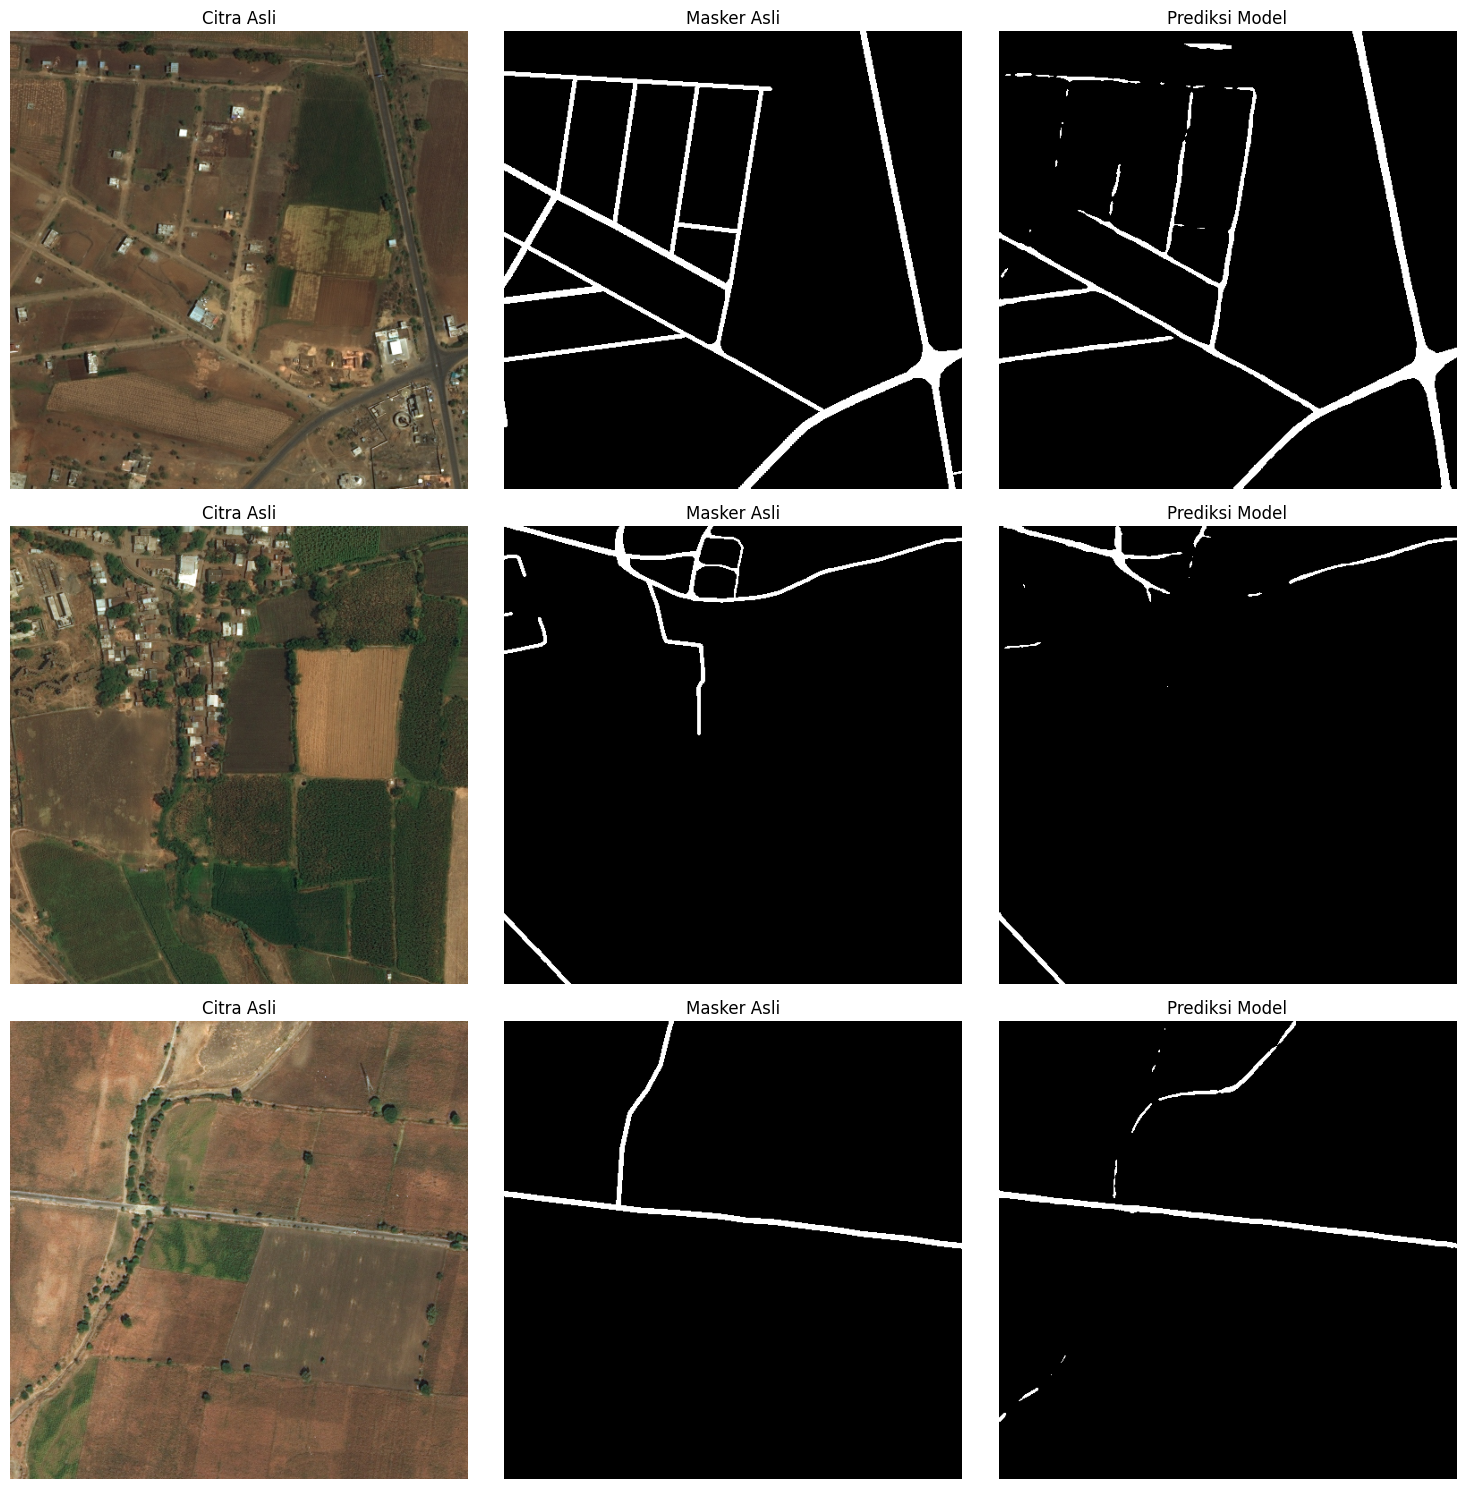

In [ ]:
# @title Sel 9: Visualisasi Hasil Prediksi
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

def visualize_prediction(dataset, model, num_images=3):
    fig, ax = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        image, mask = dataset[idx]

        with torch.no_grad():
            pred_mask = model(image.unsqueeze(0).to(DEVICE))
            pred_mask = (pred_mask > 0.5).float().cpu().squeeze(0)

        ax[i, 0].imshow(image.permute(1, 2, 0).numpy())
        ax[i, 0].set_title("Citra Asli")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(mask.squeeze(), cmap='gray')
        ax[i, 1].set_title("Masker Asli")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
        ax[i, 2].set_title("Prediksi Model")
        ax[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

visualize_prediction(val_ds, model)

Estimasi Panjang Jalan: 1055.00 meter


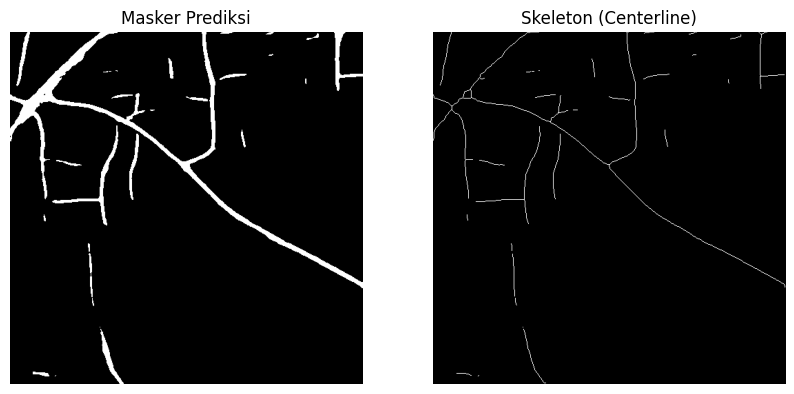

In [ ]:
# @title Sel 10: Implementasi Pengukuran Jarak
GSD = 0.5

def calculate_road_length(predicted_mask_tensor):
    """
    Menghitung panjang jalan dari tensor masker prediksi.
    """
    mask_np = predicted_mask_tensor.squeeze().cpu().numpy()
    binary_mask = (mask_np > 0).astype(np.uint8)

    skeleton = skeletonize(binary_mask)

    pixel_count = np.count_nonzero(skeleton)

    length_in_meters = pixel_count * GSD

    return length_in_meters, skeleton

# Contoh penggunaan pada satu gambar
image, mask = val_ds[10]
with torch.no_grad():
    pred_mask_tensor = model(image.unsqueeze(0).to(DEVICE))
    pred_mask_tensor = (pred_mask_tensor > 0.5).float()

length, skeleton_img = calculate_road_length(pred_mask_tensor)

print(f"Estimasi Panjang Jalan: {length:.2f} meter")

# Visualisasi skeleton
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_mask_tensor.squeeze().cpu().numpy(), cmap='gray')
plt.title("Masker Prediksi")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(skeleton_img, cmap='gray')
plt.title("Skeleton (Centerline)")
plt.axis("off")
plt.show()